# Fault detection (inference)

Now let's the whole cube

In [2]:
import os
import sys
import re
from copy import copy
import h5py

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import scipy

sys.path.append('../..')

from seismiqb import *

from seismiqb.batchflow import FilesIndex, Pipeline
from seismiqb.batchflow.research import Results
from seismiqb.batchflow.models.torch import EncoderDecoder, ResBlock, TorchModel
from seismiqb.batchflow import D, B, V, P, R, L, W

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=7


In [8]:
model_path = 'research_1d_without_transpose/results/crop_(1, 256, 256)-loss_dice-paths_16_PSDM-repetition_0-update_0/2058413201/model_2000'
inference_path = '/data/seismic_data/seismic_interpretation/CUBE_01_ETP/PREDICTIONS/FAULTS/2058413201.hdf5'
cube = '/data/seismic_data/seismic_interpretation/CUBE_01_ETP/amplitudes_01_ETP'
cube_path = cube + '.hdf5'

In [9]:
CROP_SHAPE = (1, 256, 256)
BATCH_SIZE = 40

In [10]:
# OVERLAP_SHAPE = tuple(np.maximum((np.array(CROP_SHAPE) * 3/4).astype(int), np.array([1,1,1])))
STRIDE = (1, 192, 192)

In [11]:
dataset = SeismicCubeset(FilesIndex(path=[cube_path], no_ext=True))
dataset.load(label_dir={
    'amplitudes_01_ETP': '/INPUTS/FAULTS/NPY/*',
    'amplitudes_16_PSDM': '/INPUTS/FAULTS/NPY/*',
}, labels_class=Fault, transform=True, verify=True)
geometry = dataset.geometries[0]

# Predict on WHOLE

In [12]:
geometry = dataset.geometries[0]
path_hdf5 = inference_path

! rm -r {path_hdf5}

file_hdf5 = h5py.File(path_hdf5, "a")
cube_hdf5 = file_hdf5.create_dataset('cube', geometry.cube_shape)

rm: cannot remove '/data/seismic_data/seismic_interpretation/CUBE_01_ETP/PREDICTIONS/FAULTS/2058413201.hdf5': No such file or directory


In [13]:
inference_template = (
    Pipeline()
    # Initialize everything
    .init_variable('result_preds', [])
    .load_model(mode='dynamic', model_class=TorchModel, name='model', path=model_path)
    # Load data
    .crop(points=D('grid_gen')(),
          shape=CROP_SHAPE)
    .load_cubes(dst='images')
    .adaptive_reshape(src='images', shape=CROP_SHAPE)
    .scale(mode='q', src='images')

    # Predict with model, then aggregate
    .predict_model('model',
                   B('images'),
                   fetches='sigmoid',
                   save_to=V('result_preds', mode='e'))
)

In [14]:
def split_cube(geometry, crop_shape, stride, length):
    il_min = 0
    ranges = []
    for il_max in range(length, geometry.ilines_len + stride, stride):
        if il_max >= geometry.ilines_len:
            il_max = geometry.ilines_len - 1
        if il_max - il_min >= crop_shape[0]:
            ranges += [[il_min, il_max]]
        else:
            ranges[-1][-1] = geometry.ilines_len-1
        il_min += stride
    return ranges

In [15]:
for il_min, il_max in split_cube(geometry, CROP_SHAPE, 80, 140):
    print('bounds', il_min, il_max)
    dataset.make_grid(dataset.indices[0], CROP_SHAPE,
                      [il_min, il_max], [0, geometry.xlines_len-1], [0, geometry.depth-1],
                      strides=STRIDE,
                      batch_size=8) 

    inference_pipeline = inference_template << dataset
    for _ in tqdm(range(dataset.grid_iters)):
        batch = inference_pipeline.next_batch(D('size'))

    # Write to hdf5
    slices = tuple([slice(*item) for item in dataset.grid_info['range']])
    prediction = (dataset.assemble_crops(inference_pipeline.v('result_preds'), order=(0, 1, 2)) > 0.5).astype(int)
    if il_min == 0:
        cube_hdf5[:100, slices[1], slices[2]] = prediction[0:100]
    elif il_max == geometry.ilines_len - 1:
        cube_hdf5[il_min+20:-1, slices[1], slices[2]] = prediction[20:]
    else:
        cube_hdf5[il_min+20:il_max-20, slices[1], slices[2]] = prediction[20:120]
        
    
file_hdf5.close()

  0%|          | 0/698 [00:00<?, ?it/s]

bounds 0 140


100%|██████████| 698/698 [02:07<00:00,  5.48it/s]
../../seismiqb/src/cubeset.py:806: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

../../seismiqb/src/cubeset.py:807: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

../../seismiqb/src/cubeset.py:808: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

  0%|          | 1/700 

bounds 80 220


  0%|          | 1/779 [00:00<02:00,  6.46it/s]

bounds 160 300


  0%|          | 1/939 [00:00<02:23,  6.54it/s]

bounds 240 380


  0%|          | 1/980 [00:00<02:33,  6.40it/s]

bounds 320 460


  0%|          | 1/980 [00:00<02:31,  6.48it/s]

bounds 400 540


  0%|          | 0/980 [00:00<?, ?it/s]

bounds 480 620


  0%|          | 1/980 [00:00<02:38,  6.18it/s]

bounds 560 700


  0%|          | 1/980 [00:00<02:28,  6.61it/s]

bounds 640 780


  0%|          | 1/980 [00:00<02:54,  5.61it/s]

bounds 720 860


  0%|          | 1/980 [00:00<02:32,  6.42it/s]

bounds 800 940


  0%|          | 0/980 [00:00<?, ?it/s]

bounds 880 1020


  0%|          | 1/980 [00:00<02:29,  6.56it/s]

bounds 960 1100


  0%|          | 1/980 [00:00<02:33,  6.38it/s]

bounds 1040 1180


  0%|          | 0/980 [00:00<?, ?it/s]

bounds 1120 1260


  0%|          | 1/1028 [00:00<02:35,  6.59it/s]

bounds 1200 1340


  0%|          | 1/1108 [00:00<02:51,  6.44it/s]

bounds 1280 1420


  0%|          | 1/1120 [00:00<02:51,  6.53it/s]

bounds 1360 1500


  0%|          | 1/1116 [00:00<03:16,  5.67it/s]

bounds 1440 1580


  0%|          | 1/956 [00:00<02:27,  6.50it/s]

bounds 1520 1660


  0%|          | 1/840 [00:00<02:09,  6.50it/s]

bounds 1600 1740


  0%|          | 1/840 [00:00<02:15,  6.21it/s]

bounds 1680 1820


  0%|          | 1/840 [00:00<02:07,  6.57it/s]

bounds 1760 1900


  0%|          | 1/840 [00:00<02:08,  6.54it/s]

bounds 1840 1980


  0%|          | 1/840 [00:00<02:08,  6.55it/s]

bounds 1920 2060


  0%|          | 1/840 [00:00<02:10,  6.45it/s]

bounds 2000 2140


  0%|          | 1/840 [00:00<02:09,  6.49it/s]

bounds 2080 2220


  0%|          | 1/840 [00:00<02:10,  6.45it/s]

bounds 2160 2300


  0%|          | 1/840 [00:00<02:21,  5.94it/s]

bounds 2240 2380


  0%|          | 1/840 [00:00<02:18,  6.06it/s]

bounds 2320 2460


  0%|          | 1/816 [00:00<02:05,  6.51it/s]

bounds 2400 2540


  0%|          | 1/414 [00:00<01:04,  6.41it/s]

bounds 2480 2562


100%|██████████| 414/414 [01:05<00:00,  6.32it/s]


In [19]:
geometry_sgy = SeismicGeometry(path_hdf5)

In [21]:
loc = 1000

#shape = np.array([(slc.stop - slc.start) for slc in locations])
seismic_slide = geometry.load_slide(loc)

# mask = np.zeros_like(seismic_slide.reshape(shape))
# for label in dataset.labels[0]:
#     mask = label.add_to_mask(mask, locations)
    
prediction = geometry_sgy.load_slide(loc)

In [23]:
# seismic_slide.shape, mask.shape

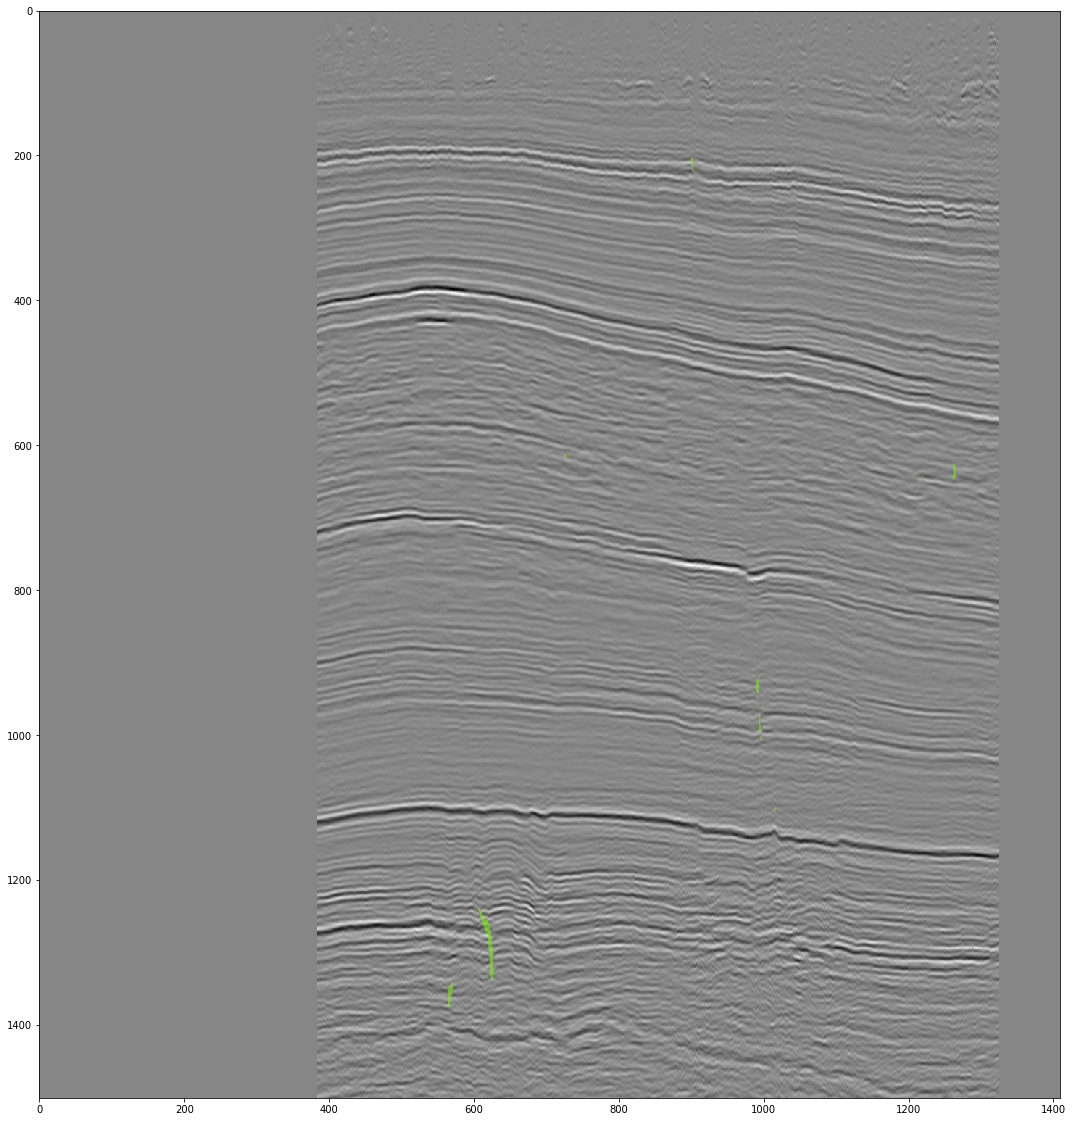

In [25]:
zoom_slice = (slice(0, 1), slice(None, None), slice(None))
# plot_image((seismic_slide[zoom_slice[1:]], mask[zoom_slice]), 
#            mode='overlap', figsize=(20, 20), colors=['blue'], show=True, opacity=0.5, savepath='target.png')
plot_image((seismic_slide[zoom_slice[1:]], prediction[zoom_slice[1:]]), 
           mode='overlap', figsize=(20, 20), colors=['lawngreen'], show=True, opacity=0.5, savepath='prediction.png')

In [ ]:
%%time
sem = semblance(geometry, locations=[[locations[i].start for i in range(3)], [locations[i].stop for i in range(3)]])

In [ ]:
def iou(target, prediction):
    target = 1 - (np.nan_to_num(target, 0))
    return (prediction * target).sum() / prediction.sum()

In [ ]:
# semblance = scipy.ndimage.generic_filter(seismic_slide,
#                                          compute_marfurt_semblance,
#                                          window)

In [ ]:
sem.shape, prediction.shape

In [ ]:
iou(sem, prediction), iou(sem, mask[0])

In [21]:
# prediction[semblance > 0.9] = 0

zoom_slice = (slice(0, 1), slice(None, None), slice(1000, 1500))
plot_image((sem[zoom_slice]), figsize=(20, 20), cmap='gray', show=True, colorbar=True)
plot_image((sem[zoom_slice], mask[zoom_slice], prediction[zoom_slice[1:]]), figsize=(20, 20), mode='overlap', color=('red', 'blue'), show=True) 

NameError: name 'sem' is not defined

In [ ]:
# for slide in range(800):
#     mask = geometry_sgy.load_slide(slide)
#     if mask.sum() > 0:
#         print(slide, mask.sum())

slide = loc# dataset.labels[0][1].points[0, 0]

zoom_slice = (slice(None, None), slice(1000, 1500))


dataset.show_slide(slide, figsize=(20, 20), width=1, zoom_slice=zoom_slice)

mask = geometry_sgy.load_slide(slide)
slide = dataset.geometries[0].load_slide(slide)
plot_image((slide[:, zoom_slice[1]], mask[:, zoom_slice[1]]), mode='overlap', figsize=(20, 20), zoom_slice=zoom_slice)

In [ ]:
mask.sum()